In [11]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.1 MB 9.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler


import warnings

warnings.filterwarnings('ignore')

In [ ]:
! apt-get update
! apt-get install -y fonts-nanum
! fc-cache -fv
! rm -rf ~/.cache/matplotlib/*

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
%cd /workspace/

/workspace


## 양극 인장강도 Regression

In [6]:
df = pd.read_csv('./data/processed/양극/rule_based_final.csv')# 원본 그대로 읽으면 불필요한 아래 시각화 정보까지 읽게 됨

,Unnamed: 0,lo_height_mean_mean,lo_height_min_mean,lo_height_peak_mean,lo_height_std_mean,lo_fwhm_mean,lo_area_mean,br_peak_mean,br_peak_time_mean,br_diff_peak_mean,...,nir_over_area_std,nir_extra_time_std,nir_extra_area_std,nir_sum_area_std,vis_peak_std,vis_reach_time_std,vis_over_area_std,vis_extra_time_std,vis_extra_area_std,실인장
0,0,2.442401,1.599957,2.505109,0.118677,149.981481,242.966096,9.458099,32.944444,9.376149,...,0.0,1.499543,0.0,2.581494,0.020383,13.380267,0.0,0.662539,0.0,6.4
1,1,2.866036,1.868954,2.937511,0.148194,149.981481,286.374286,9.269230,21.240741,9.228344,...,0.0,3.207288,0.0,2.521932,0.030545,5.666667,0.0,0.882889,0.0,14.5
2,2,2.876868,2.223283,2.936535,0.090764,149.981481,286.240578,9.127098,19.518519,9.087128,...,0.0,2.799667,0.0,3.284553,0.033232,5.541340,0.0,0.683180,0.0,5.0
3,3,2.877258,2.176069,2.941891,0.090610,149.981481,286.216852,9.276842,21.685185,9.236034,...,0.0,2.786406,0.0,3.278251,0.025890,5.231670,0.0,0.554320,0.0,9.2
4,4,3.027043,2.296706,3.087433,0.099107,149.981481,301.340732,9.090552,19.092593,9.052898,...,0.0,1.596571,0.0,3.475178,0.028190,6.215164,0.0,0.864043,0.0,10.5
5,5,3.024694,2.067526,3.087965,0.115836,149.981481,301.600921,9.098966,18.703704,9.056967,...,0.0,6.402294,0.0,2.776010,0.027447,5.529941,0.0,0.948611,0.0,8.0
6,6,3.024750,2.073642,3.088977,0.115668,149.981481,301.596295,9.130898,18.611111,9.090455,...,0.0,6.608595,0.0,3.642455,0.032458,5.336965,0.0,0.608581,0.0,21.2
7,7,3.180735,2.557451,3.243088,0.091168,149.981481,316.868130,9.043223,16.240741,9.005263,...,0.0,6.387815,0.0,3.615654,0.043164,6.623834,0.0,0.711458,0.0,21.7
8,8,3.174311,2.238811,3.240945,0.124236,149.981481,316.879019,8.973297,17.388889,8.926983,...,0.0,2.593915,0.0,3.605911,0.032286,4.947738,0.0,0.895806,0.0,19.9
9,9,3.177429,2.288077,3.242094,0.109100,149.981481,316.109195,8.982931,17.222222,8.939562,...,0.0,3.373015,0.0,3.420855,0.033157,5.582435,0.0,0.558326,0.0,35.3


In [7]:
# Data Pre-processing: Use data up to row 38
data_selected = df.copy()

# Define features and target 
#features = data_selected.drop(columns=["File Name", "실인장"])
features = data_selected.drop(columns=["Unnamed: 0", "실인장"])

target = data_selected["실인장"]

In [10]:
features.columns

Index(['lo_height_mean_mean', 'lo_height_min_mean', 'lo_height_peak_mean',
       'lo_height_std_mean', 'lo_fwhm_mean', 'lo_area_mean', 'br_peak_mean',
       'br_peak_time_mean', 'br_diff_peak_mean', 'nir_peak_mean',
       'nir_reach_time_mean', 'nir_over_area_mean', 'nir_extra_time_mean',
       'nir_extra_area_mean', 'nir_sum_area_mean', 'vis_peak_mean',
       'vis_reach_time_mean', 'vis_over_area_mean', 'vis_extra_time_mean',
       'vis_extra_area_mean', 'lo_height_mean_std', 'lo_height_min_std',
       'lo_height_peak_std', 'lo_height_std_std', 'lo_fwhm_std', 'lo_area_std',
       'br_peak_std', 'br_peak_time_std', 'br_diff_peak_std', 'nir_peak_std',
       'nir_reach_time_std', 'nir_over_area_std', 'nir_extra_time_std',
       'nir_extra_area_std', 'nir_sum_area_std', 'vis_peak_std',
       'vis_reach_time_std', 'vis_over_area_std', 'vis_extra_time_std',
       'vis_extra_area_std'],
      dtype='object')

In [11]:
features.tail(5) #  마지막 시편 기록에서 s.BR9.5over_길이_MEAN의 값이 0을 기록하고 있는데, 결측치를 일괄 처리한 것인지 아니면 실제 feature가 0인지 확인 필요

,lo_height_mean_mean,lo_height_min_mean,lo_height_peak_mean,lo_height_std_mean,lo_fwhm_mean,lo_area_mean,br_peak_mean,br_peak_time_mean,br_diff_peak_mean,nir_peak_mean,...,nir_reach_time_std,nir_over_area_std,nir_extra_time_std,nir_extra_area_std,nir_sum_area_std,vis_peak_std,vis_reach_time_std,vis_over_area_std,vis_extra_time_std,vis_extra_area_std
34,2.596492,1.997430,2.653972,0.070602,149.981481,257.148173,9.323603,25.981481,9.272550,0.270320,...,8.772482,0.0,2.412601,0.0,3.118543,0.021113,9.540848,0.0,0.828173,0.0
35,2.590818,1.914259,2.651034,0.094128,149.981481,257.725828,9.265807,24.037037,9.214012,0.286451,...,11.270234,0.0,2.353237,0.0,3.625650,0.024889,10.657403,0.0,0.825062,0.0
36,2.732908,1.968330,2.795427,0.099937,149.981481,271.789219,9.224851,22.148148,9.182942,0.302431,...,6.649283,0.0,2.325088,0.0,2.717908,0.027203,6.150936,0.0,0.864043,0.0
37,2.738527,2.130543,2.794847,0.072475,149.981481,271.490398,9.354470,24.148148,9.312052,0.304980,...,6.994830,0.0,2.335684,0.0,2.793837,0.023117,6.054763,0.0,0.704921,0.0
38,2.734172,1.899191,2.795553,0.096720,149.981481,272.130185,9.346655,23.148148,9.304201,0.298953,...,6.604572,0.0,3.290934,0.0,2.808780,0.019598,5.708872,0.0,0.738190,0.0


In [12]:
sum(features.isna().sum()>0) # 결측치 확인 -> 결측치 없음.

0

In [13]:
target.isna().sum() # 결측치 확인 -> 결측치 없음.

0

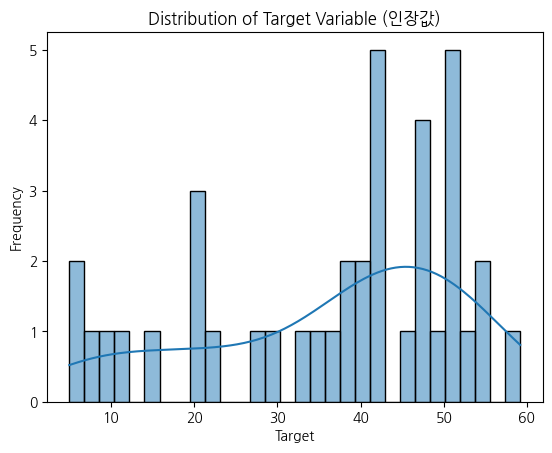

In [14]:
# EDA: Visualizations
# Histogram of the target variable
sns.histplot(target, bins=30, kde=True)
plt.title('Distribution of Target Variable (인장값)')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

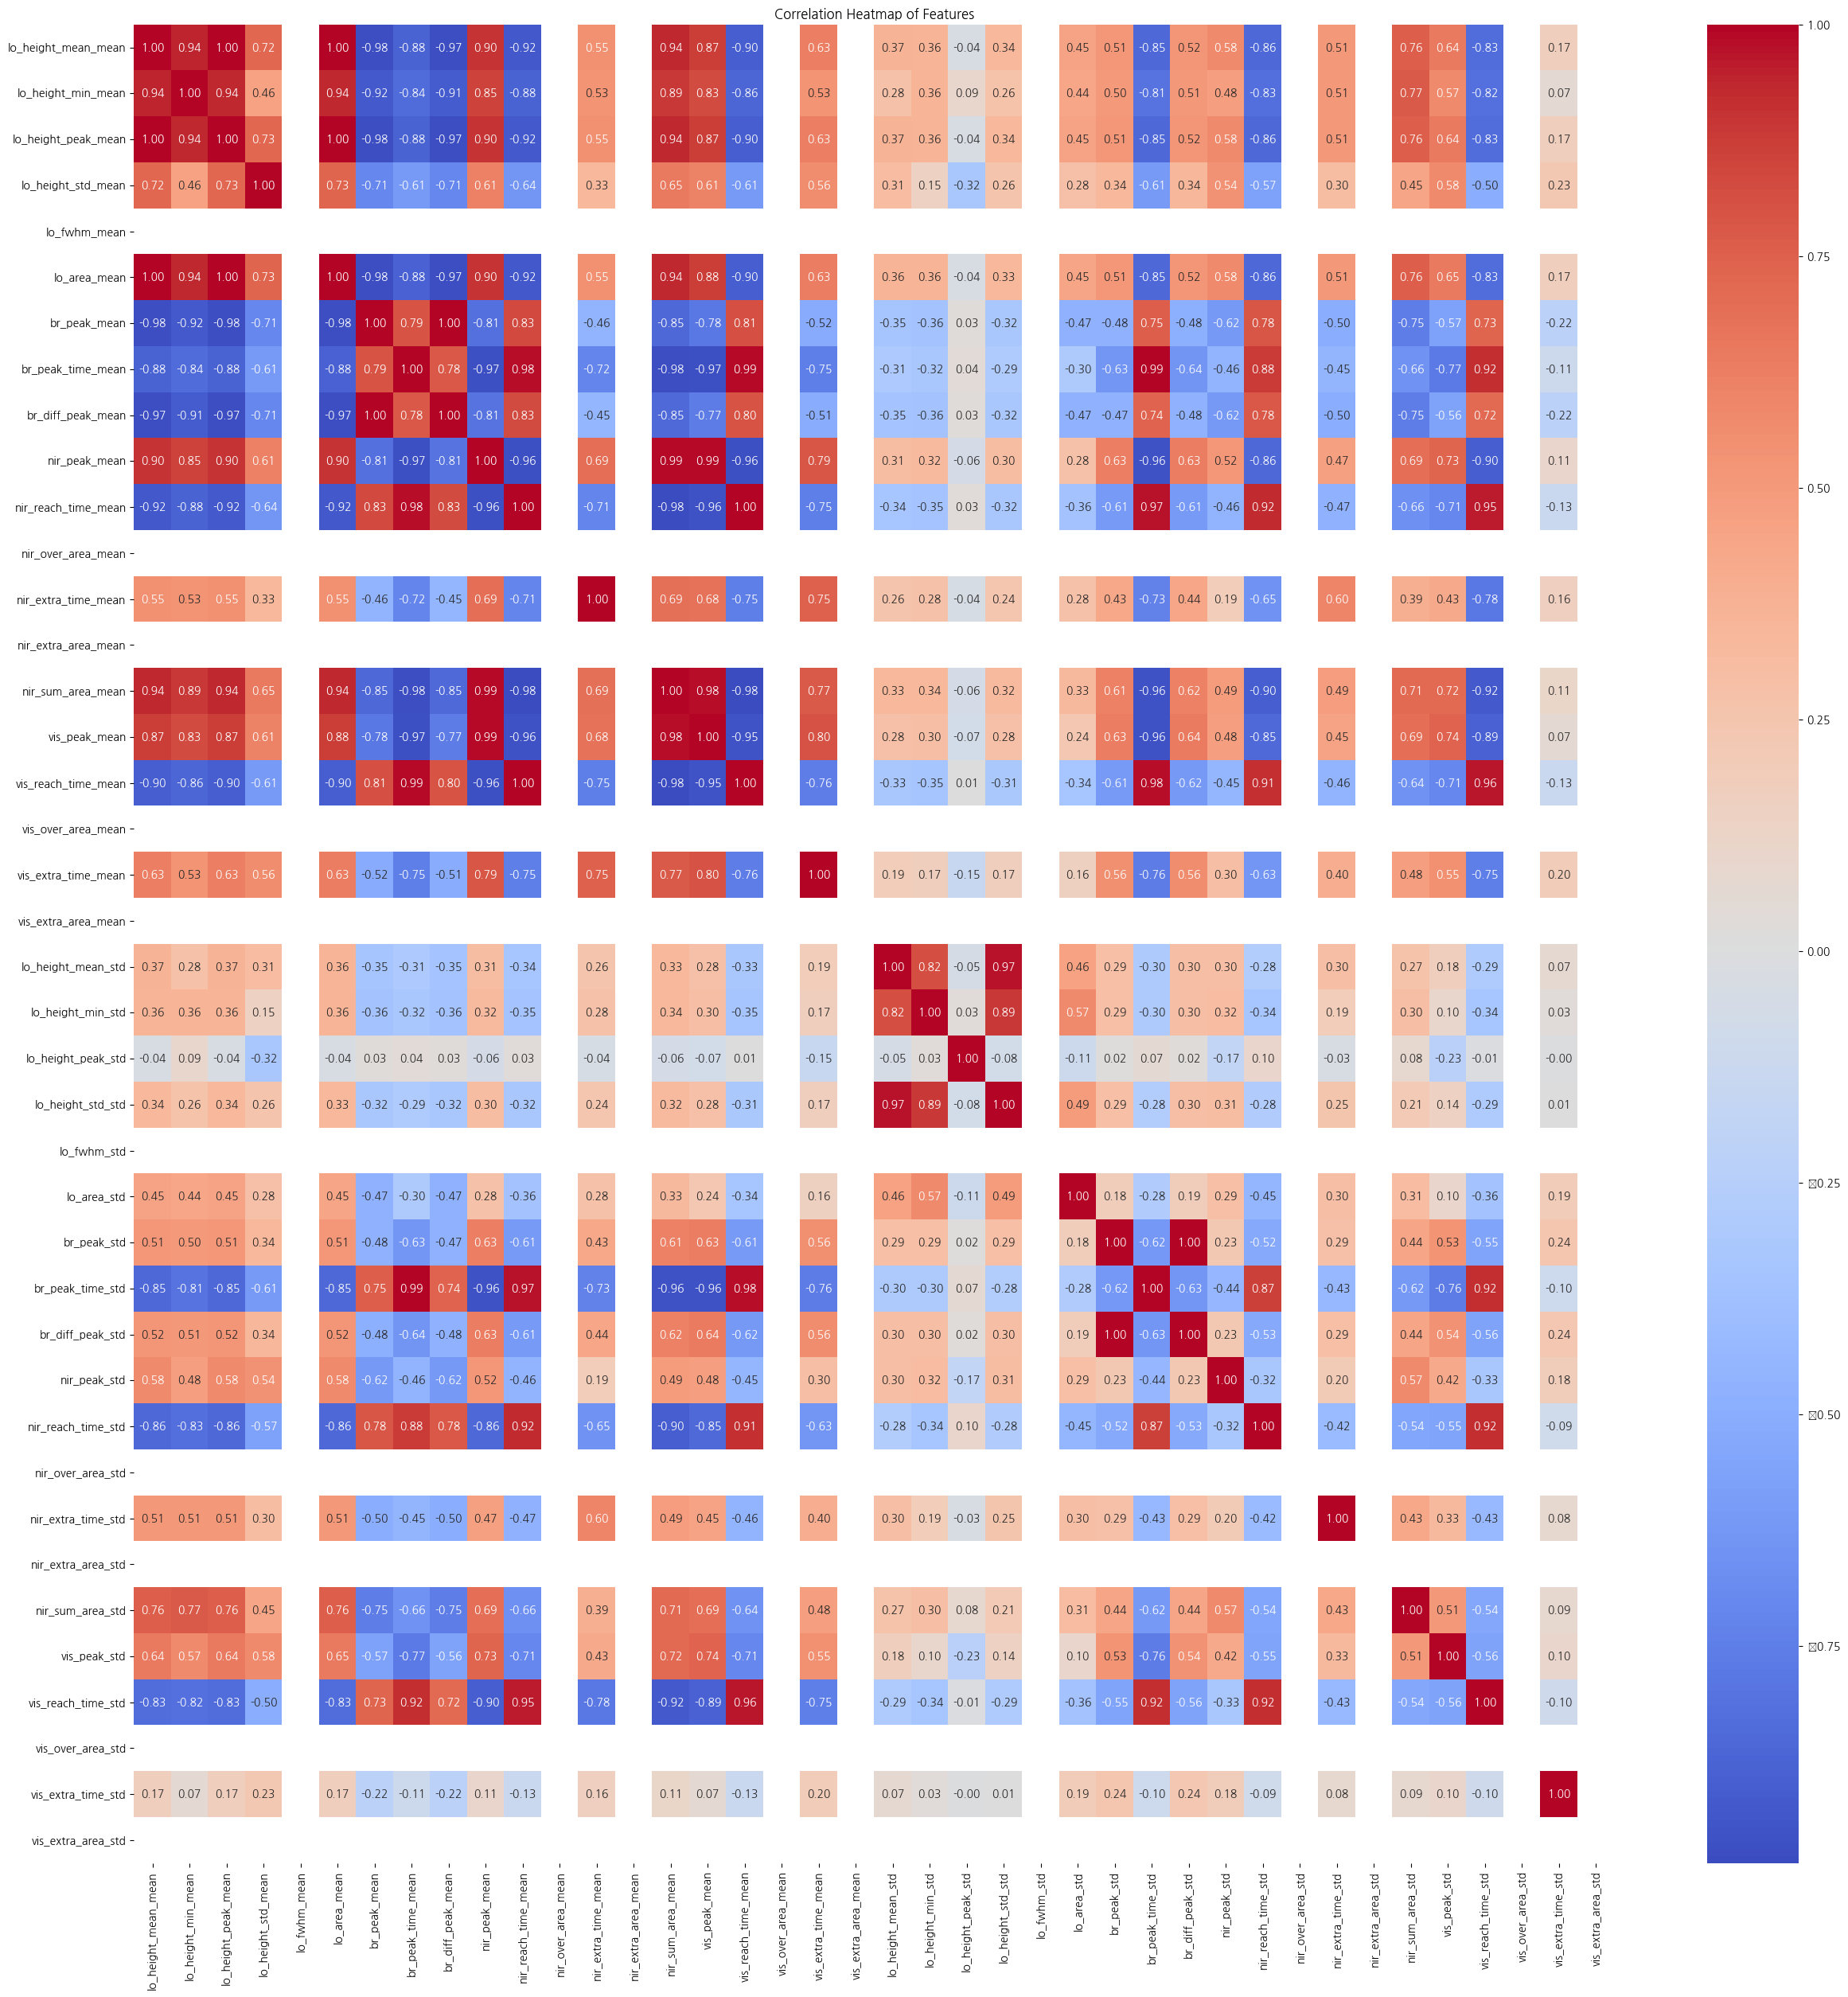

In [15]:
# Correlation heatmap of features 

plt.figure(figsize=(30, 30))
sns.heatmap(features.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [16]:
np.random.seed(42)

# Modeling with LOOCV
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective ='reg:squarederror', random_state=42,
                            tree_method='gpu_hist', 
                            gpu_id=0,
                            ),
    
    'LightGBM': LGBMRegressor(
                        min_data_in_leaf=1, 
                        min_split_gain=0.0, 
                        num_leaves=31, 
                        max_depth=-1,
                        lambda_l1=0.0,
                        lambda_l2=0.0,
                        learning_rate=0.05,
                        n_estimators=500,
                        random_state=42,
                        device='cpu',
                        verbose=-1
                        )
}

loocv = LeaveOneOut()

results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE'])

In [17]:
from collections import defaultdict
from tqdm import tqdm
feat_import = defaultdict(list)
 
for model_name, model in models.items():
    mse_values = []
    rmse_values = []
    mape_values = []
    mae_values = []
    
    predictions = []
    actuals = []
    
    for train_index, test_index in tqdm(loocv.split(features)):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Normalize data
        scaler = StandardScaler().fit(X_train)  # Compute mean and std on training data
        X_train_scaled = scaler.transform(X_train)  # Scale training data
        X_test_scaled = scaler.transform(X_test)  # Scale test data using training parameters
        
        # Train model
        model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        prediction = model.predict(X_test_scaled.reshape(1,-1))
        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - prediction) / y_test)) * 100
        mae = np.mean(np.abs(y_test - prediction))

        mse_values.append(mse)
        rmse_values.append(rmse)
        mape_values.append(mape)
        mae_values.append(mae)

    try:
        # Extract feature importances
        importances = model.feature_importances_
        
        # Create a DataFrame for visualization
        feature_importances = pd.DataFrame({
            'Feature': features.columns,
            'Importance': importances
        })
        
        # Sort features according to importance
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        feat_import[model_name] = feature_importances

    except AttributeError:
        print(f"{model_name} does not support feature_importances_")

    agg_mse = np.mean(mse_values)
    agg_rmse = np.mean(rmse_values)
    agg_mape = np.mean(mape_values)
    agg_mae = np.mean(mae_values)

    results = results.append({
        'Model': model_name,
        'MSE': agg_mse,
        'RMSE': agg_rmse,
        'MAPE' : agg_mape,
        'MAE' : agg_mae
    }, ignore_index=True)

    print(f"{model_name} - MSE: {agg_mse:.2f}, RMSE: {agg_rmse:.2f}, MAPE: {agg_mape:.2f}, MAE: {agg_mae:.2f}")

39it [00:00, 164.75it/s]


Linear Regression does not support feature_importances_
Linear Regression - MSE: 2636.20, RMSE: 39.78, MAPE: 157.83, MAE: 39.78


39it [00:00, 119.98it/s]


Ridge Regression does not support feature_importances_
Ridge Regression - MSE: 414.42, RMSE: 17.01, MAPE: 86.62, MAE: 17.01


39it [00:00, 163.46it/s]


Lasso Regression does not support feature_importances_
Lasso Regression - MSE: 245.77, RMSE: 13.24, MAPE: 76.35, MAE: 13.24


39it [00:01, 27.03it/s]


Gradient Boosting - MSE: 151.14, RMSE: 10.00, MAPE: 52.67, MAE: 10.00


39it [00:08,  4.66it/s]


XGBoost - MSE: 222.81, RMSE: 11.81, MAPE: 67.14, MAE: 11.81


39it [00:09,  4.23it/s]

LightGBM - MSE: 265.21, RMSE: 12.52, MAPE: 55.38, MAE: 12.52


In [18]:
results # 변수간 상관관계가 태생적으로 높기 때문에 다중공산성으로 인해 Linear Regression의 성능이 좋지 않음. 규제화를 적용했을때 성능이 향상함. PCA를 통해 상관관계를 제거한 뒤에 PC를 사용하여 모델링을 하는 것도 고려할 수 있음

,Model,MSE,RMSE,MAPE,MAE
0,Linear Regression,2636.204235,39.783979,157.830006,39.783979
1,Ridge Regression,414.415851,17.010745,86.615786,17.010745
2,Lasso Regression,245.774752,13.236999,76.353934,13.236999
3,Gradient Boosting,151.141197,10.000187,52.665002,10.000187
4,XGBoost,222.813463,11.812031,67.139199,11.812031
5,LightGBM,265.206387,12.515322,55.377465,12.515322


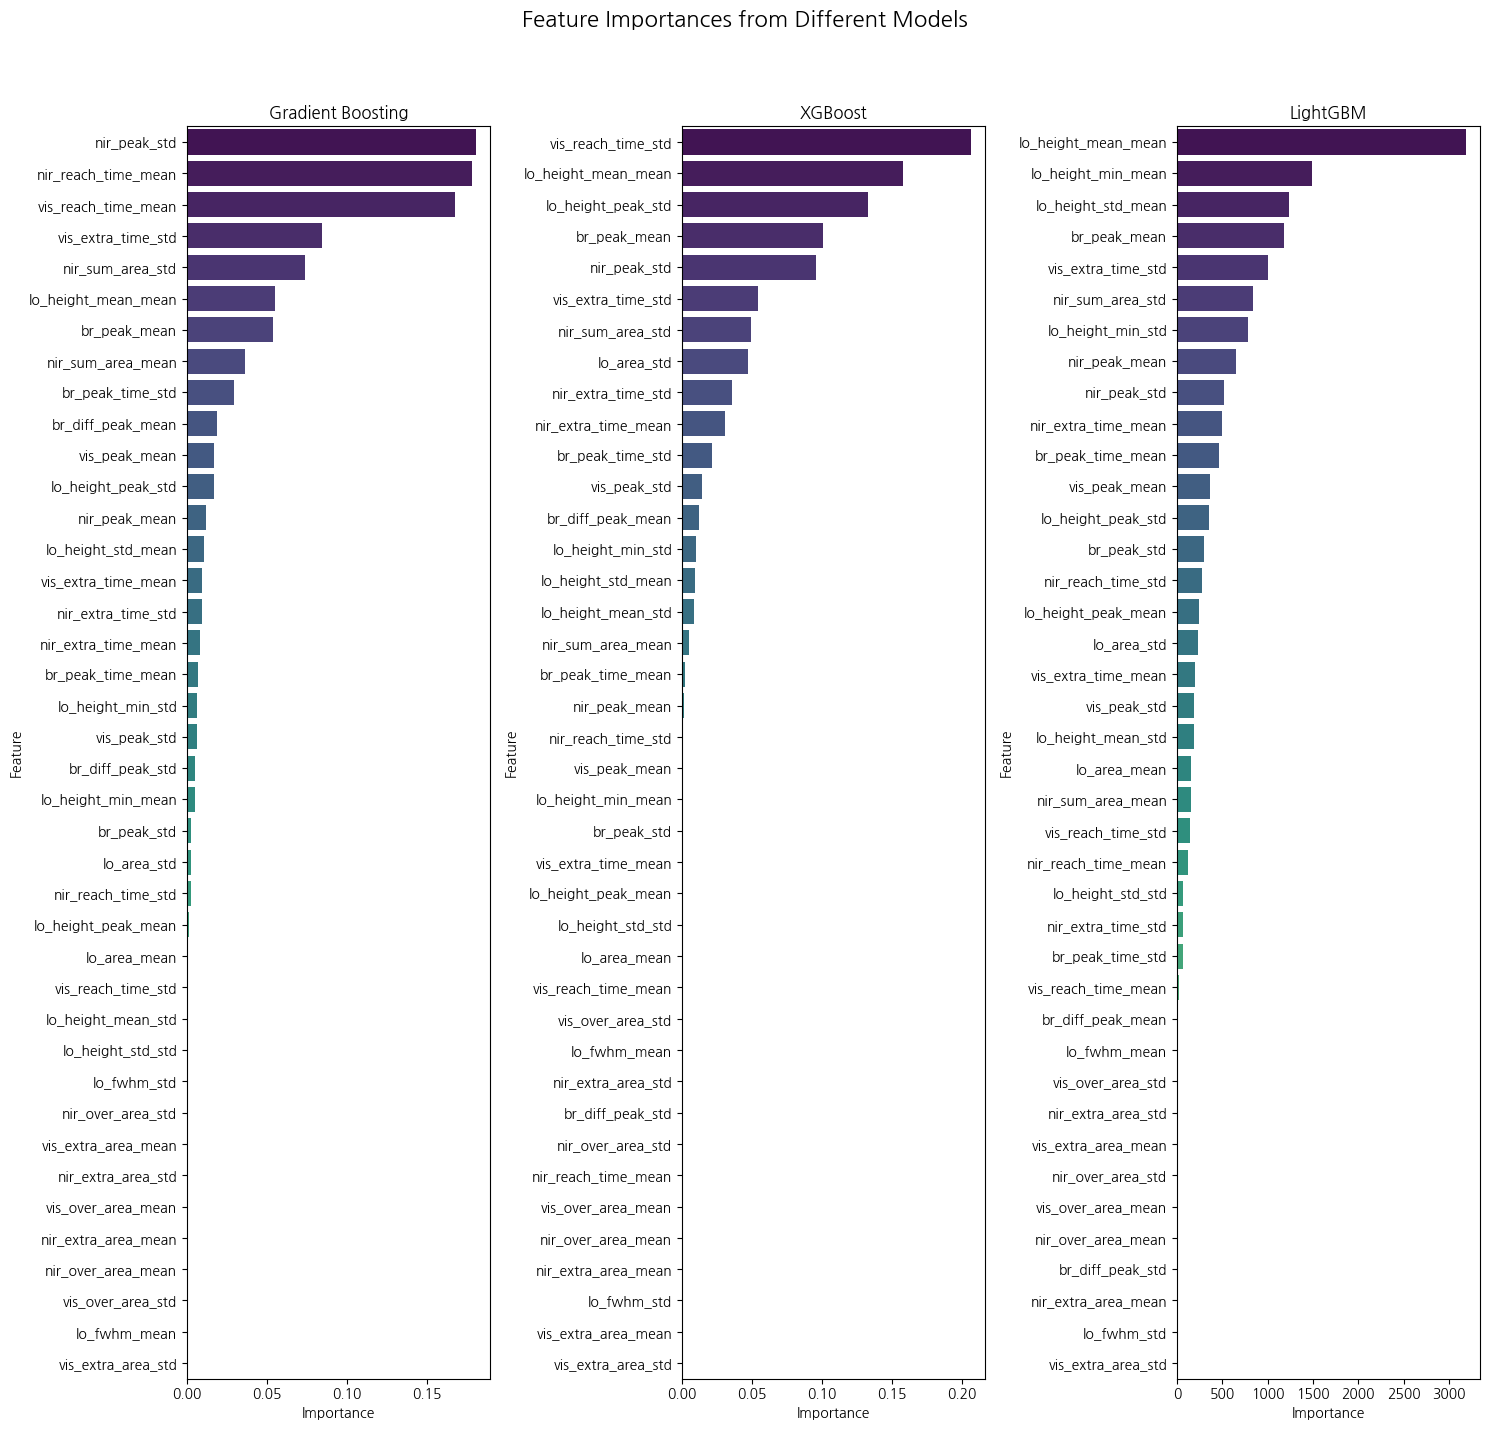

In [19]:
model_import = ['Gradient Boosting', 'XGBoost', 'LightGBM']

# Set up the matplotlib figure
num_models = len(model_import)
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 15))
fig.suptitle('Feature Importances from Different Models', fontsize=16)

# Plotting
for ax, model_name in zip(axes, model_import):

    feature_importances = feat_import[model_name]
    
    # Plot
    sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax, palette='viridis')
    ax.set_title(model_name)
    ax.set_xlabel('Importance')
    
axes[0].set_ylabel('Feature')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()

In [20]:
features_best = data_selected[feat_import['Gradient Boosting']['Feature'][:5]]
feat_import_best = defaultdict(list)


mse_values = []
rmse_values = []
predictions = []
actuals = []

model_name = 'Gradient Boosting'
model = models[model_name]

for train_index, test_index in loocv.split(features_best):
    X_train, X_test = features_best.iloc[train_index], features_best.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Normalize data
    scaler = StandardScaler().fit(X_train)  # Compute mean and std on training data
    X_train_scaled = scaler.transform(X_train)  # Scale training data
    X_test_scaled = scaler.transform(X_test)  # Scale test data using training parameters
    
    # Train model
    model.fit(X_train_scaled, y_train)

    # Predict and evaluate
    prediction = model.predict(X_test_scaled.reshape(1,-1))
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)

    mse_values.append(mse)
    rmse_values.append(rmse)
    
    agg_mse = np.mean(mse_values)
    agg_rmse = np.mean(rmse_values)

print(f"{model_name} - MSE: {agg_mse:.2f}, RMSE: {agg_rmse:.2f}")


Gradient Boosting - MSE: 121.62, RMSE: 8.29
